In [1]:
train_features_path = '/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_features_master_5_pcs_avg_band.csv'
test_features_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_features_master_5_pcs_avg_band.csv'

In [2]:
from dataframe import Data
from io_utils import *
import matplotlib.pyplot as plt

In [3]:
from pandas import DataFrame

In [4]:
from prediction_evaluation import PredictionEvaluation

In [5]:
sample_numbers_train = {101:1000,
               102:1000,
               103:1000, 
               112:1000, 
               113:1000, 
               114:1000, 
               141:100,
               143:1000,
               145:100,
               150:100, 
               151:100, 
               160:100, 
               161:100, 
               162:100, 
               163:1000, 
               164:1000, 
               170:100, 
               180:100, 
               181:100, 
               183:100, 
               190:100}
#sample_numbers_train=None

In [6]:
sample_numbers_test = {101:1000,
               102:1000,
               103:1000, 
               112:1000, 
               113:1000, 
               114:1000, 
               141:100,
               143:1000,
               145:100,
               150:100, 
               151:100, 
               160:100, 
               161:100, 
               162:1000, 
               163:1000, 
               164:1000, 
               170:1000, 
               180:0, 
               181:0, 
               183:0, 
               190:0}
sample_numbers_test=None

In [7]:
sample_numbers_train=None
sample_numbers_test=None

In [8]:
train_ob = load_ztf_train_data(head_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_master_HEAD.FITS', phot_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/train_master_PHOT.FITS')
test_ob = load_ztf_test_data(head_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_master_HEAD.FITS', phot_path='/media/biswajit/drive/Kilonova_datasets/ZTF_20190512/test_master_PHOT.FITS')

In [9]:
num_pc_components = 5
prediction_type_nos= 163
color_band_dict = {'g':'C2', 'r':'C3'}

In [10]:
#catch error if data_ob and path are not compatible 
train_ob.create_features_df(prediction_type_nos=prediction_type_nos, 
                            band_choice='all', 
                            num_pc_components=num_pc_components, 
                            min_flux_threshold =200,
                            #skip_random_date_event_types = [150,151],
                            #plot_predicted_curve_of_type=[163],
                            #plot_all_predictions=True,
                            color_band_dict=color_band_dict,
                            sample_numbers=sample_numbers_train, 
                            features_path=train_features_path,
                            #num_alert_days=50,
                            #use_random_current_date=False
                           )

In [11]:
test_ob.create_features_df(color_band_dict=color_band_dict, 
                           min_flux_threshold=200,
                           #save_fig_path = 'ZTF_CART_5_pc_ex/3_pc/', 
                           prediction_type_nos=prediction_type_nos, 
                           band_choice='all',
                           #num_alert_days=30,
                           #plot_predicted_curve_of_type = [150,151],
                           #plot_all_predictions = True,
                           features_path = test_features_path,
                           num_pc_components=num_pc_components, 
                           sample_numbers=sample_numbers_test, 
                           use_random_current_date=False)

In [12]:
use_number_of_points = True
bands = ['g', 'r']

cols = []
for i,band in enumerate(bands):
    for j in range(1,num_pc_components+1):
        if use_number_of_points:
            if j ==1:
                col_name = str(i)+'n'
                cols.append(col_name)
        col_name = str(i)+'pc'+str(j)
        cols.append(col_name)
        

        
x_train = train_ob.features_df[cols].values
y_train = train_ob.features_df['y_true'].values

        
x_test = test_ob.features_df[cols].values
y_test = test_ob.features_df['y_true'].values

#y_train_binary = keras.utils.to_categorical(y_train, 2)
#y_test_binary = keras.utils.to_categorical(y_test, 2)

In [13]:
len(y_train)

21780

In [14]:
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

In [17]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 128) 
        self.layer_2 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        #self.sigmoid = nn.sigmoid(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        #x = self.sigmoid(x)
        return x

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [19]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [20]:
EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [21]:
from torch.utils.data import Dataset, DataLoader

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(x_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(x_test))


In [22]:


validation_split = 0.2

dataset_len = len(train_data)
indices = list(range(dataset_len))

# Randomly splitting indices:
val_len = int(np.floor(validation_split * dataset_len))
validation_idx = np.random.choice(indices, size=val_len, replace=False)
train_idx = list(set(indices) - set(validation_idx))

from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)


train_loader = DataLoader(dataset=train_data, sampler=train_sampler, batch_size=BATCH_SIZE)
validation_loader = DataLoader(dataset=train_data, sampler=validation_sampler, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [36]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss(reduction = 'none')
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [24]:
data_loaders = {"train": train_loader, "val": validation_loader}
data_lengths = {"train": len(train_idx), "val": len(validation_idx)}

In [39]:
n_epochs = 100

In [40]:
model1 = binaryClassification()
model1.to(device)
print(model1)
criterion = nn.BCEWithLogitsLoss(reduction = 'none')
optimizer = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

from torch.autograd import Variable
model1.train()
val_losses = []
train_losses = []
for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            #optimizer = scheduler(optimizer, epoch)
            model1.train(True)  # Set model1 to training mode
        else:
            model1.train(False)  # Set model1 to evaluate mode

       

        # Iterate over data.
        data_loader = data_loaders[phase]
        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data


                        # zero the parameter gradients
            #optimizer.zero_grad()
            inputs, labels = Variable(inputs), Variable(labels)
            # forward + backward + optimize
            outputs = model1(inputs)
            sample_weight = labels.unsqueeze(1)*19 +1
            loss = criterion(outputs, labels.unsqueeze(1))

            #print(sample_weight)
            #print(loss.shape)
            loss = loss*sample_weight
            #print('____________')
            #print(loss.shape)
            #print(sample_weight.shape)
            loss = loss.mean()
            #print(phase+str(loss))
            # zero the parameter (weight) gradients
            #optimizer.zero_grad()
            optimizer.zero_grad()


            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()

            # print loss statistics
            running_loss += loss.item()

        epoch_loss = running_loss / data_lengths[phase]
        print('{} Loss: {:f}'.format(phase, epoch_loss))
        if phase == 'train':
            train_losses.append(epoch_loss)
        
        if phase == 'val':
            val_losses.append(epoch_loss)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 0/99
----------
train Loss: 0.009889
val Loss: 0.008738
Epoch 1/99
----------
train Loss: 0.009412
val Loss: 0.008763
Epoch 2/99
----------
train Loss: 0.009062
val Loss: 0.008592
Epoch 3/99
----------
train Loss: 0.008933
val Loss: 0.008718
Epoch 4/99
----------
train Loss: 0.008866
val Loss: 0.008169
Epoch 5/99
----------
train Loss: 0.008696
val Loss: 0.008506
Epoch 6/99
----------
train Loss: 0.008634
val Loss: 0.009634
Epoch 7/99
----------
train Loss: 0.008540
val Loss: 0.008241
Epoch 8/99
----------
train Loss

In [41]:
print(val_losses)

[0.008738007386197072, 0.008763341877961838, 0.0085922875078147, 0.008717755011400026, 0.008168774038635338, 0.008505881017397257, 0.009634046392007307, 0.008240526988486613, 0.008906706456091559, 0.008331957263777954, 0.00835815915637765, 0.00836514512588389, 0.009009194686064707, 0.008531794424063575, 0.009163015295432399, 0.009445006593966068, 0.008350931593756593, 0.00886537311162502, 0.00843656024766472, 0.008051391318098353, 0.008512533558028022, 0.008362310675987965, 0.008413378611083858, 0.007933124735664073, 0.009809081192077903, 0.008658418122292441, 0.008003439182968069, 0.007846030404088255, 0.00808240415116206, 0.008342333822156225, 0.008057113240846698, 0.008976858557365268, 0.007776107738278567, 0.008087291889392093, 0.008341799508113179, 0.008055894458589475, 0.008042124417311999, 0.008422468052586904, 0.0079690343858563, 0.008700666499313026, 0.007883609942168244, 0.008176252847970134, 0.00819396828981142, 0.007989466422954975, 0.008672861083042086, 0.00764102737108866

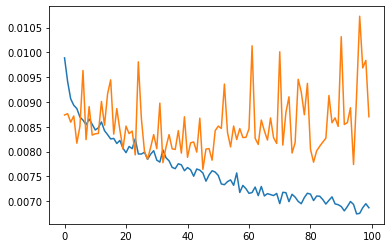

In [42]:
plt.plot(train_losses)
plt.plot(val_losses)

In [37]:
model.train()

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        sample_weight = labels.unsqueeze(1)*24 +1
        loss = criterion(outputs, labels.unsqueeze(1))
        
        #print(sample_weight)
        #print(loss.shape)
        loss = loss*sample_weight
        #print('____________')
        #print(loss.shape)
        #print(sample_weight.shape)
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        #print(loss)

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 15.679913
[1,    20] loss: 14.865586
[1,    30] loss: 13.472161
[1,    40] loss: 13.956436
[1,    50] loss: 14.273119
[1,    60] loss: 13.635736
[1,    70] loss: 13.942458
[1,    80] loss: 13.076932
[1,    90] loss: 14.817381
[1,   100] loss: 13.490769
[1,   110] loss: 12.297833
[1,   120] loss: 14.146632
[1,   130] loss: 14.066186
[2,    10] loss: 13.481967
[2,    20] loss: 13.323001
[2,    30] loss: 14.478917
[2,    40] loss: 13.230146
[2,    50] loss: 15.223249
[2,    60] loss: 13.964761
[2,    70] loss: 13.163463
[2,    80] loss: 12.416057
[2,    90] loss: 12.902806
[2,   100] loss: 13.586446
[2,   110] loss: 12.973812
[2,   120] loss: 13.097819
[2,   130] loss: 12.682286
[3,    10] loss: 14.673753
[3,    20] loss: 13.363650
[3,    30] loss: 13.819645
[3,    40] loss: 13.570524
[3,    50] loss: 12.170559
[3,    60] loss: 11.871943
[3,    70] loss: 12.680755
[3,    80] loss: 12.201052
[3,    90] loss: 12.881412
[3,   100] loss: 11.267397
[3,   110] loss: 13.713383
[

[24,    10] loss: 10.674322
[24,    20] loss: 11.864446
[24,    30] loss: 11.364778
[24,    40] loss: 11.179542
[24,    50] loss: 11.698301
[24,    60] loss: 10.805155
[24,    70] loss: 11.472787
[24,    80] loss: 11.261524
[24,    90] loss: 11.607233
[24,   100] loss: 11.281711
[24,   110] loss: 11.365143
[24,   120] loss: 11.693140
[24,   130] loss: 10.396075
[25,    10] loss: 12.153910
[25,    20] loss: 10.919460
[25,    30] loss: 14.036040
[25,    40] loss: 12.238691
[25,    50] loss: 10.351863
[25,    60] loss: 10.923100
[25,    70] loss: 11.141599
[25,    80] loss: 12.291265
[25,    90] loss: 11.214055
[25,   100] loss: 10.565931
[25,   110] loss: 12.031448
[25,   120] loss: 11.619421
[25,   130] loss: 10.895762
[26,    10] loss: 11.649844
[26,    20] loss: 10.663925
[26,    30] loss: 11.786357
[26,    40] loss: 11.619559
[26,    50] loss: 11.164571
[26,    60] loss: 13.273278
[26,    70] loss: 11.651118
[26,    80] loss: 12.143488
[26,    90] loss: 11.192460
[26,   100] loss: 11

[47,    20] loss: 10.045794
[47,    30] loss: 11.188510
[47,    40] loss: 11.245020
[47,    50] loss: 12.045106
[47,    60] loss: 11.424399
[47,    70] loss: 9.907590
[47,    80] loss: 10.590814
[47,    90] loss: 9.635347
[47,   100] loss: 10.982627
[47,   110] loss: 11.830678
[47,   120] loss: 10.282881
[47,   130] loss: 11.348414
[48,    10] loss: 10.776750
[48,    20] loss: 11.282402
[48,    30] loss: 9.981937
[48,    40] loss: 11.262251
[48,    50] loss: 10.534678
[48,    60] loss: 10.073086
[48,    70] loss: 9.899105
[48,    80] loss: 10.007348
[48,    90] loss: 10.600477
[48,   100] loss: 10.471650
[48,   110] loss: 9.900630
[48,   120] loss: 11.035315
[48,   130] loss: 11.196869
[49,    10] loss: 11.393036
[49,    20] loss: 12.540843
[49,    30] loss: 9.491463
[49,    40] loss: 10.335220
[49,    50] loss: 11.036023
[49,    60] loss: 9.729758
[49,    70] loss: 11.553210
[49,    80] loss: 10.818807
[49,    90] loss: 11.456406
[49,   100] loss: 9.988478
[49,   110] loss: 10.140317


In [48]:
y_pred_test_list = []
model1.eval()
with torch.no_grad():
    for X_batch in test_loader:
        
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_test_list.append(y_pred_tag.cpu().numpy())

y_pred_test_list = [a.squeeze().tolist() for a in y_pred_test_list]

In [49]:
print(y_pred_test_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [50]:
confusion_matrix(y_test, y_pred_test_list)

array([[19571,   217],
       [  957,    43]])

In [51]:
print(y_pred_test_list[0])

0.0


In [43]:
y_pred_train_list = []
model.eval()
with torch.no_grad():
    for batch_data in train_loader:
        
        X_batch, labels = batch_data
        X_batch = X_batch.to(device)
        
        y_train_pred = model(X_batch)
        y_train_pred = torch.sigmoid(y_train_pred)
        y_pred_tag = torch.round(y_train_pred)
        y_pred_train_list.append(y_pred_tag.cpu().numpy())
print(y_pred_train_list[0].squeeze().tolist())

with torch.no_grad():
    y_pred_train=model(torch.FloatTensor(x_train))
y_pred_train_list = [a.squeeze(-1).tolist() for a in y_pred_train_list]

[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]


In [44]:

with torch.no_grad():
    y_train_pred=model(torch.FloatTensor(x_train))
    
y_train_pred = torch.sigmoid(y_train_pred)
y_pred_tag = torch.round(y_train_pred)
y_pred_train_list = y_pred_tag.squeeze().tolist()

In [45]:
print(y_pred_train_list[0])

0.0


In [46]:
from prediction_evaluation import PredictionEvaluation
pe = PredictionEvaluation(train_ob=train_ob, test_ob=test_ob,
                          y_pred_train=y_pred_train_list, 
                          y_pred_test=y_pred_test_list)

TypeError: list indices must be integers or slices, not tuple

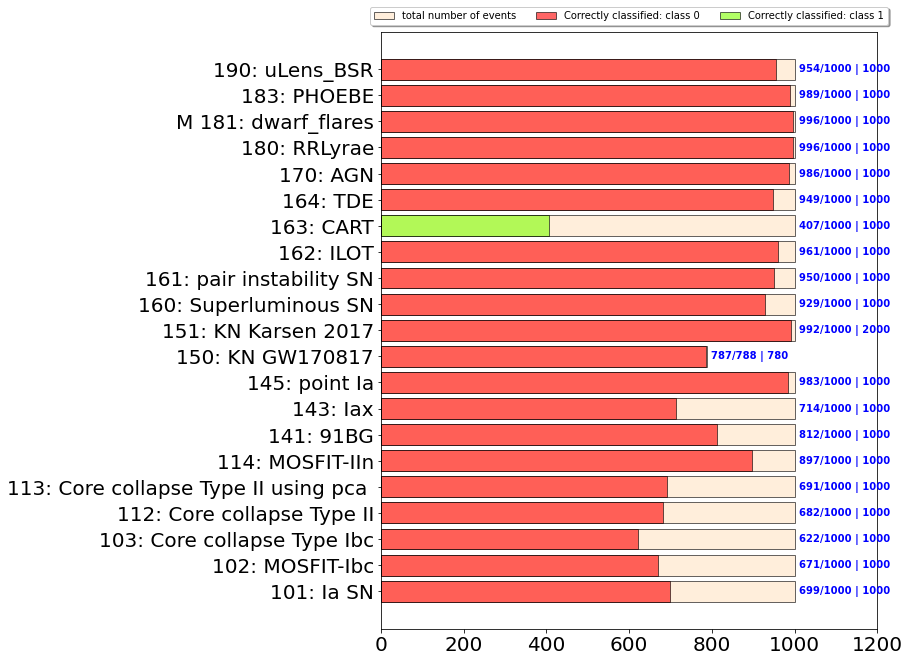

In [47]:
fig = pe.plot_performance_statistics(y_score=y_pred_test_list)
fig.savefig(save_fig_base_path+"performance_stat"+save_fig_postfix_path)
#fig.savefig("randomplt")
plt.show()
plt.close('all')